 #Anomoly/Outlier Detection in Clustering

Clutering and other machine learning techniques are great for helping us to determine trends in data that we can then use to better inform our decisions. This is an extremely useful tool for just about any field that exists as it can greatly speed up processes for workers. However, with any data set there will generally be outliers that cannot be easily explained. This can be due to any number of different things, but we need to be able to identify these as they can make the decision making process more challenging. 

Doing this can be tough as mistakes in anomoly detection can lead to valid data potentially being overlooked in our findings. Depedning on the technique we are using the way to figure out which points are outliers. For example, with dbscan the outliers are determined as part of the process of fitting the data to the model. This is due to the fact that dbscan works by considering the distance between a point and its nearest neighbors. If the next nearest point is within the preset limits then it adds it to the same cluster and determines it's neighbors until it finds all of the points in that cluster. Once the the algorthim is finished, any points that were to far from the rest are not included in any of the clusters and are then considered anomolies or outliers. With tools like sklearn we can actually get a data set of just these points that we can then work with to determine if they are infact outliers or if the model needs to be adjusted to better include the points. Of course, for some applications this is not acceptable as you cannot garuntee that every point will be included in the analysis and still get accurate results. 

With other types of methods, the process of determining outliers is a bit more complex. For example, both KMeans and gaussian matrix techniques will include all data points in at least one cluster that they find. This makes them ideal for situations in which we need to be sure that every data point is considered, but we have to come up with other ways to pick out outliers. To demonstrate this, I am going to use the data and model from a previous post about clustering. 

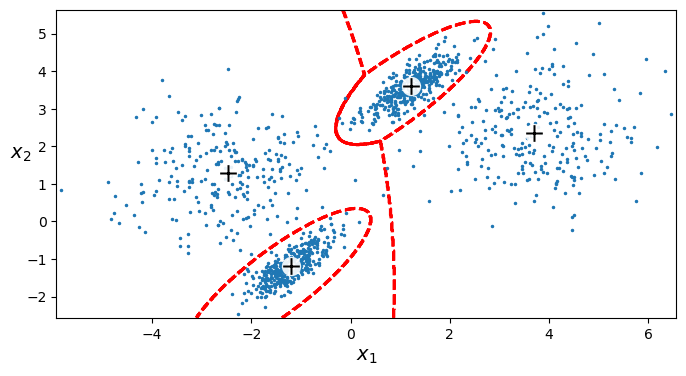

In [9]:
import sys

assert sys.version_info >= (3, 7)
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from pathlib import Path

IMAGES_PATH = Path() / "images" / "ForGaussianMatrix"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
    
from sklearn.datasets import make_blobs
import numpy as np


X1, y1 = make_blobs(n_samples=750, centers=((-2, 10), (-2, -2)), random_state=27)
X1 = X1.dot(np.array([[0.4, 0.2], [0.2, 0.4]]))
X2, y2 = make_blobs(n_samples=500, centers=2, random_state=27)
X2 = X2 + [-1, -5]
X = np.r_[X1, X2]
y = np.r_[y1, y2]


def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)
    
    
from sklearn.mixture import GaussianMixture
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]


gm = GaussianMixture(n_components=4, n_init=10, random_state=27)
gm.fit(X)

from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='+', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], '.', markersize=3)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)


plt.show()


This data has been generated using sklearn's makeblob function. There are four distinct clusters in this data which I have used a gaussian matrix to seperate from each other. The crosses mark the centroids of each of the distinct clusters. The red dashed lines represent the decision boundaries of each of the clusters in between which each point is considered to be in that cluster. 

It is pretty clear that some of these points are very distant from their respective cluster or potentially between a few different ones. We will probably want to take note of these or even exclude them from our considerations as we work with the data. The simplest way to do this is to essentially set a threshhold beyond which if any points do not meet the threshold they will be considered an outlier. This threshold can be determined by many things. If we are working in a production environment or somewhere were the data input could be wrong we might expect a specific percentage of the data to be anomolies or outliers. We can use this expected rate as our threshold.

With this in mind, we will first calculate the density or log-likelihood of each sample. Then we will calculate what the threshold value is and apply it to the data to figure out which points do not meet it.  

In [10]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

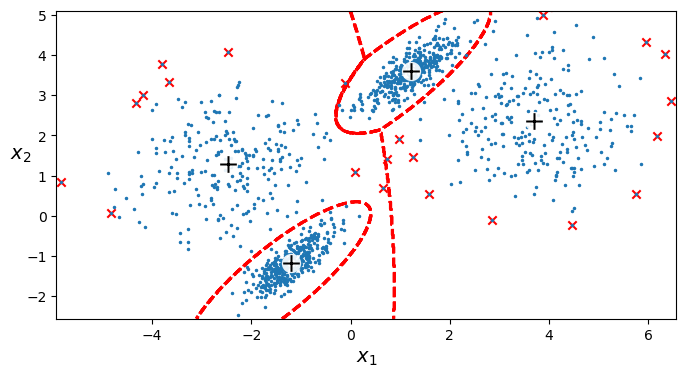

In [11]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='x')
plt.ylim(top=5.1)


plt.show()

With the points seperated, we can use matplot to plot markers for each of the outliers as can be seen above marked by the red "x" marks. By marking these we can see that most of the points do in fact sit far from their respective culster centroids which makes them less likely to be in a cluster and more likely to be an outlier. Then we could take this data and try to understand where they are coming from. This can give us information about our processes to reduce the chance for errors in the future or maybe understand a different user we are not currently catering to well. 